In [1]:
using GaussianProcesses, Plots, SumProductNetworks
using StatsFuns, Distributions, LaTeXStrings
using PGFPlots
import SumProductNetworks.add!

In [2]:
using Colors
cm = colormap("grays")

#### include local code

In [3]:
include("utilFunctions.jl")
include("dataTypes.jl")
include("dataTypeUtilFunctions.jl")
include("computationFunctions.jl")
include("regionGraph.jl")
include("regionGraphUtils.jl")
include("gpUtils.jl")

LoadError: LoadError: [91mUndefVarError: @showprogress not defined[39m
while loading /charming/martint/code/SPNs/GP-SPN/playground/regionGraphUtils.jl, in expression starting on line 28

# Load data

In [4]:
datapath = "../data/clean/motor.csv"
(data, header) = readcsv(datapath, header = true)
headerDict = Dict(col[2] => col[1] for col in enumerate(header))
X = convert(Vector, data[:,headerDict["times"]])
y = convert(Vector, data[:,headerDict["accel"]]);
y /= maximum(y);

In [5]:
reshape(X, 1, length(X))

1×94 Array{Float64,2}:
 2.4  2.6  3.2  3.6  4.0  6.2  6.6  …  50.6  52.0  53.2  55.0  55.4  57.6

In [6]:
pgfplots()

Plots.PGFPlotsBackend()

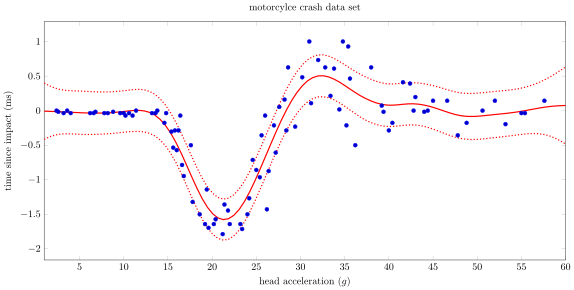

In [16]:
xmin = 1
xmax = 60
S = 100

xx = linspace(xmin,xmax,S)

kernel_function = Mat52Iso(log(5.0), log(1.0))
gp = GP(reshape(X, 1, length(X)), y, MeanZero(), kernel_function, -1.)
optimize2!(gp, mean = false, kern = true, noise = false, lik=false)
μgp, σgp = predict_y(gp,xx);

p = Axis([
        PGFPlots.Linear(X, y, onlyMarks=true, style="blue"),
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        ], 
    xlabel=L"head acceleration ($g$)", 
    ylabel="time since impact (ms)", 
    title="motorcylce crash data set",
    width="20cm", height="10cm",
    xmin=xmin, xmax=xmax)

PGFPlots.save("../plots/motorcyle_data_gp.pdf", p)
p

# Construct a region graph

Set some parameters

In [141]:
exp(-1)

0.36787944117144233

In [404]:
global gID = 1

numGPs = 5
meanFunction = MeanZero();
kernelFunctions = [SE(log(5.0),log(1.0))];
kernelFunctions = [Mat12Iso(log(5.0), log(1.0)), Mat32Iso(log(5.0), log(1.0)), Mat52Iso(log(5.0), log(1.0))]
#kernelFunctions = [LinIso(log(5.0))]
kernelFunctions = [LinIso(log(5.0)), SE(log(5.0),log(1.0))]
noise = -1.;

# put some priors on the parameters
#set_priors!(kernelFunction, [Normal(log(5.0),1.0), Normal(log(1.0),1.0)])

In [408]:
# split size
δ = 10

# data range
minX = 0
maxX = 60

overlap = 0

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX, maxX);
# set IDs for convenients
RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
root1 = convertToSPN(rootRegion, gpRegions, X, y, meanFunction, kernelFunctions, noise; overlap = overlap)

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX+(δ/2), maxX+(δ/2));
# set IDs for convenients
RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
root2 = convertToSPN(rootRegion, gpRegions, X, y, meanFunction, kernelFunctions, noise; overlap = overlap)


Gaussian Process Sum Node [ID: 2354, 
	 w_prior: [0.2, 0.2, 0.2, 0.2, 0.2], 
	 w_posterior: [0.2, 0.2, 0.2, 0.2, 0.2]]

# Posterior Inference over SPN-GP

In [409]:
function spn_mcmc(spn::GPSumNode, gpNodes::Vector;
              sampler::Klara.MCSampler=Klara.HMC(),
              nIter::Int = 1000,
              burnin::Int = 0,
              thin::Int = 1)
    
    gps = map(n -> n.gp, gpNodes)
    
    function logpost(hyp::Vector{Float64})  #log-target
        
        for (i, gp) in enumerate(gps)
            p = get_params(gp)
            e = (i*2)
            s = s-1
            p[2:3] = hyp[s:e]
            set_params!(gp, p)
            update_target!(gp)
        end
        
        dirty!(spn)
        spn_update!(spn)
        return spn_posterior(spn)
    end

    function dlogpost(hyp::Vector{Float64}) #gradient of the log-target
        Kgrad_buffer = Array{Float64}(gp.nobsv, gp.nobsv)
        for (i, gp) in enumerate(gps)
            p = get_params(gp)
            e = (i*2)
            s = s-1
            p[2:3] = hyp[s:e]
            set_params!(gp, p)
            update_target_and_dtarget!(gp, noise=false, mean=false, kern=true)
            println(gp.dtarget)
        end
        
        dirty!(spn)
        spn_update!(spn)
        
        return gp.dtarget
    end
    
    start = reduce(vcat, map(gp -> get_params(gp)[2:3], gps))
    starting = Dict(:p=>start)
    q = BasicContMuvParameter(:p, logtarget=logpost, gradlogtarget=dlogpost) 
    model = likelihood_model(q, false)                               #set-up the model
    job = BasicMCJob(model, sampler, BasicMCRange(nsteps=nIter, thinning=thin, burnin=burnin), starting)   #set-up MCMC job
    print(job)                                             #display MCMC set-up for the user
    
    run(job)                          #Run MCMC
    chain = Klara.output(job)         # Extract chain
    #set_params!(gp,start)      #reset the parameters stored in the GP to original values
    return chain
end

spn_mcmc (generic function with 1 method)

In [410]:
#leafs = filter(n -> isa(n, GPLeaf), SumProductNetworks.getOrderedNodes(root))

In [411]:
#spn_mcmc(root, leafs)

## Define root

In [412]:
root = GPSumNode(nextID(), Int[]);


for child in children(root1)
    add!(root, child)
end

for child in children(root2)
    add!(root, child)
end

fill!(root.prior_weights, 1. / length(root))
fill!(root.posterior_weights, 1. / length(root))

for gpnode in unique(filter(n -> isa(n, GPLeaf), SumProductNetworks.getOrderedNodes(root)))
    iparams = copy(get_params(gpnode.gp.k))
    res = optimize2!(gpnode.gp, mean = false, kern = true, noise = false, lik=false)
end

spn_update!(root)
spn_posterior(root)

-32.91975859278023

## Plotting

spn_density (generic function with 1 method)

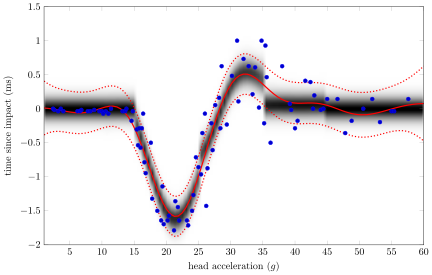

In [414]:
xmin = 1
xmax = 60

ymax = 1.5
ymin = -2

xx = linspace(xmin,xmax,S)
μgp, σgp = predict_y(gp,xx);

p = Axis([
        PGFPlots.Linear(X, y, onlyMarks=true, style="blue"),
        PGFPlots.Image((x,y) -> spn_density(root, x, y), (xmin, xmax), (ymin, ymax), colormap = ColorMaps.RGBArrayMap(cm), colorbar=false),
        
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        
        ], 
    xlabel=L"head acceleration ($g$)", 
    ylabel="time since impact (ms)", 
    #title="motorcylce crash data set",
    width="15cm", height="10cm",
    xmin=xmin, xmax=xmax,
    ymin=ymin, ymax=ymax)

#PGFPlots.save("../plots/motorcyle_data_overlap.pdf", p)
p

# demo_epinf.m

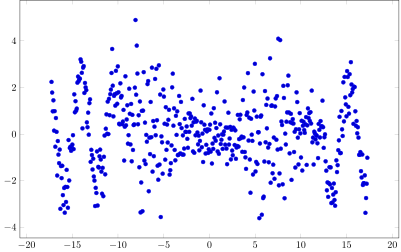

In [94]:
# Create toy data
n = 501;
x = linspace(-100,200,n);

f1 = 5.*sin.(-3+0.2.*x[1:Int(ceil(0.23*n))])
f1 = vcat(f1, 0*sin.(0.1*x[Int(ceil(0.23*n))+1:Int(ceil(0.85*n))]))
f1 = vcat(f1, 5.*sin.(2.8+0.2.*x[Int(ceil(0.85*n))+1:end]))
    
f2 = 100*normpdf.(110, 20, x) + 100*normpdf.(-10, 20, x)
sigma2 = 0.5;

x = x-mean(x)
x = x./std(x)
f1 = f1-mean(f1)
f1 = f1./std(f1)

y = f1 + sqrt.((sigma2.*exp.(f2))).*randn(size(x))
yt = f1[1:2:end]
xt = x[1:2:end]
nt = size(xt, 1)
x=x[:]*10
y=y[:];
xt=xt[:];

Axis(PGFPlots.Linear(x, y, onlyMarks=true), width="15cm", height="10cm")

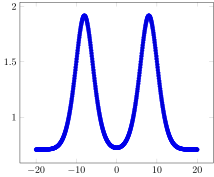

In [95]:
PGFPlots.Linear(linspace(-20,20,n), sqrt.((sigma2.*exp.(f2))), onlyMarks=true)

In [142]:
global gID = 1

numSums = 1
numGPs = 5
meanFunction = MeanZero();
kernelFunctions = [LinIso(log(5.0)), Mat32Iso(log(5.0), log(1.0))]
kernelFunctions = [Mat52Iso(log(5.0), log(1.0))]

noise = log(0.7);

# split size
δ = 6

# data range
minX = -20
maxX = 20
overlap = 0

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX, maxX);
# set IDs for convenients
RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
root1 = convertToSPN(rootRegion, gpRegions, x, y, meanFunction, kernelFunctions, noise; overlap = overlap)

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos(δ, minX+(δ/2), maxX+(δ/2));
# set IDs for convenients
RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));
root2 = convertToSPN(rootRegion, gpRegions, x, y, meanFunction, kernelFunctions, noise; overlap = overlap)

Gaussian Process Sum Node [ID: 281, 
	 w_prior: [0.167, 0.167, 0.167, 0.167, 0.167, 0.167], 
	 w_posterior: [0.167, 0.167, 0.167, 0.167, 0.167, 0.167]]

In [143]:
root = GPSumNode(nextID(), Int[]);


for child in children(root1)
    add!(root, child)
end

for child in children(root2)
    add!(root, child)
end

spn_update!(root1)
spn_posterior(root1)

spn_update!(root2)
spn_posterior(root2)

fill!(root.prior_weights, 1. / length(root))
fill!(root.posterior_weights, 1. / length(root))

for gpnode in unique(filter(n -> isa(n, GPLeaf), SumProductNetworks.getOrderedNodes(root)))
    iparams = copy(get_params(gpnode.gp.k))
    res = optimize2!(gpnode.gp, mean = false, kern = true, noise = true, lik=false)
end

#spn_update!(root)
#spn_posterior(root)

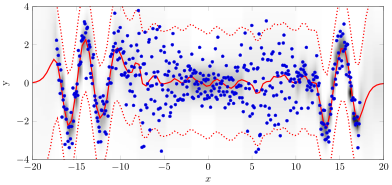

In [144]:
xmin = -2*10
xmax = 2*10

ymax = 4
ymin = -4

xx = linspace(xmin,xmax,S)

kernel_function = Mat52Iso(log(5.0), log(1.0))
gp = GP(reshape(x, 1, length(x)), y, MeanZero(), kernel_function, log(0.7))
optimize2!(gp, mean = false, kern = true, noise = true, lik=false)
μgp, σgp = predict_y(gp,xx);

p = Axis([
        PGFPlots.Linear(x, y, onlyMarks=true, style="blue", markSize=1.5),
        PGFPlots.Image((x,y) -> spn_density(root, x, y), (xmin, xmax), (ymin, ymax), ybins=100, xbins = 100, colormap = ColorMaps.RGBArrayMap(cm), colorbar=false),
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        
        ], 
    xlabel=L"x", 
    ylabel="y", 
    #title="synthetic data set",
    width="14cm", height="7cm",
    xmin=xmin, xmax=xmax,
    ymin=ymin, ymax=ymax)

PGFPlots.save("../plots/nonstationary_noise_overlap.pdf", p)
p

In [145]:
xx2 = linspace(-20,20,n)
yy = zeros(length(xx2))

for (i,xi) in enumerate(xx2)
    r = Dict{Int, SPNGParamResult}()
    spn_wavelength(root1, xi, r)
    yy[i] = exp(r[root1.id].lognoise)
    
    spn_wavelength(root2, xi, r)
    yy[i] += exp(r[root2.id].lognoise)
    
    yy[i] /= 2
end

#map(x -> spn_wavelength(root, x), xx);

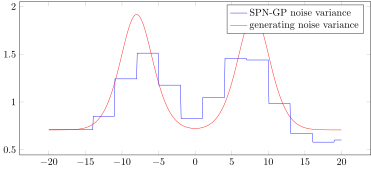

In [146]:
Axis([
        PGFPlots.Linear(xx2, yy[:], mark="none", legendentry="SPN-GP noise variance"),
        PGFPlots.Linear(linspace(-20,20,n), sqrt.((sigma2.*exp.(f2))), mark="none", legendentry="generating noise variance")
    ],
    width="14cm", height="7cm")

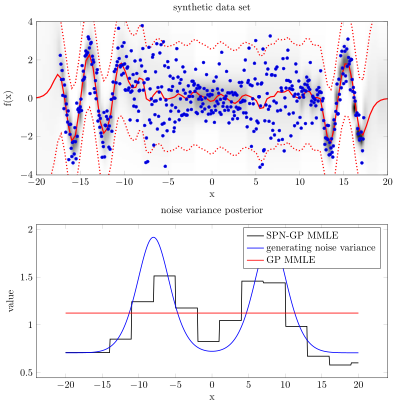

In [140]:
g = GroupPlot(1, 2, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.75cm")

push!(g, 
    Axis([
        PGFPlots.Linear(x, y, onlyMarks=true, style="blue", markSize=1.5),
        PGFPlots.Image((x,y) -> spn_density(root, x, y), (xmin, xmax), (ymin, ymax), ybins=100, xbins = 100, colormap = ColorMaps.RGBArrayMap(cm), colorbar=false),
        PGFPlots.Linear(xx, μgp, mark="none", style="red,very thick"),
        PGFPlots.Linear(xx, μgp + 2*σgp, mark="none", style="red,dotted,very thick"),
        PGFPlots.Linear(xx, μgp - 2*σgp, mark="none", style="red,dotted,very thick")
        
        ], 
    xlabel="x", 
    ylabel="f(x)", 
    title="synthetic data set",
    width="14cm", height="7cm",
    xmin=xmin, xmax=xmax,
    ymin=ymin, ymax=ymax)
)


push!(g, Axis([
        PGFPlots.Linear(xx2, yy[:], mark="none", legendentry="SPN-GP MMLE", style="black,thick"),
        PGFPlots.Linear(linspace(-20,20,n), sqrt.((sigma2.*exp.(f2))), mark="none", legendentry="generating noise variance", style="blue,thick"),
        PGFPlots.Linear(linspace(-20,20,n), ones(n) * exp(gp.logNoise), mark="none", legendentry="GP MMLE", style="red,thick")
    ],
    xlabel="x", 
    ylabel="value",
    title="noise variance posterior",
    width="14cm", height="7cm"))

PGFPlots.save("../plots/nonstationary_data.pdf", g)
g